# Coursework



Candidate number: 22817

Date submitted: 19/12/2019

### Abstract



Two exoplanets were identified to be orbiting around a Kepler star system using the 'primary transit' detection method. This method involves observing dips in the emitted flux by the star caused by an exoplanet moving in front of the star. The paper demonstrated multiple data reduction techniques and how they can be used in a varied of situations. Aperture photometry was explored as a concept of measuring a star’s flux and magnitude. The GROND dataset was reduced using bias frame subtraction and flat fielding. Using a standard star of known absolute magnitude +19.50 the absolute magnitude of a star in the image was determined to be +17.33 +/- 0.62.

Normalised lightcurves were created from the Kepler data by applying a median filter. From a periodogram two exoplanets of period 19.237 (Planet 1) and 38.98 (Planet 2) days were discovered. Their radii (Jupiter radii), semi major axis and densities (Jupiter densities) were also calculated. For Planet 1 these were 0.738 +/-0.123, 0.141 AU and 0.340 +/-0.170 respectively. For Planet 2 these were 0.674 +/-0.135, 0.226 Au and 0.741 +/- 0.371.

The properties of the two exoplanets suggest that both exoplanets are low density gas giants that have formed close to their host star. It was concluded that the extrasolar system was unlike our own, with no possibility of hosting in a form that we know. Spectroscopy was suggested as was to follow up investigations to gain an understanding into the exoplanet’s atmospheres allowing us to determine the mass compositions.


In [1]:
#Necessary imports
from astropy.io import fits #used to open fits files in which data are stored
import pylab #plotting
import glob
import numpy as np
import matplotlib as plt
import photutils
import pandas as pd
import scipy.signal

from scipy.signal import savgol_filter
from scipy import interpolate
from scipy.optimize import curve_fit
from scipy.signal import medfilt
from photutils import aperture_photometry
from imgdatareduction import ImageData
from matplotlib.colors import LogNorm
from scipy.signal import lombscargle
from matplotlib import pyplot

import seaborn as sns
from scipy import optimize
from scipy.interpolate import interpn
from CompSample import read_exopars, linfit, Zrecal, conflevels, density_scatter

mykepler = '1' #Data source number for object 1 is '1'


### 1. Introduction

An exoplanet is any planetary body that exists outside of the Solar System. Most exoplanets are detected in orbit around a host star or stars. However, exoplanets can exist outside of extrasolar systems, but detection of these exoplanets is difficult with current methods and technology [1].  Exoplanets are difficult to directly image using current telescopes because the luminosity of the host star is much greater than that of the planet. Instead indirect methods of observing the effects of the exoplanet on the star are used to confirm the presence of an exoplanet. The ‘primary transit’ and the ‘radial velocity’ are the most common methods of detecting exoplanets orbiting around a host star. The purpose of this paper is to explore how the primary transit method is used to detect an exoplanet. Using this method one can determine the period and size of the exoplanet orbiting the star [2]. When an exoplanet passes in front of a host star, the planet blocks a small percentage of the light emitted from the star. This change in flux can be detected if the planet’s transit is in the plane of observation. Knowing the baseline luminosity of the star from the Kepler lightcurve one can calculate the change in flux, this is called the transit depth. The transit depth is equal to the ratio areas of the exoplanet and star [3]. Therefore, the radius of the exoplanet cannot be measured from just the transit across the star. One must also measure the radius of the star in order to calculate the exoplanet’s radius [3]. Rearranging equation 3, one can derive the exoplanets semi major axis.

$\text{Transit Depth} = (R_{exoplanet}/R_{star})^{2}$ (1)

$ R_{exoplanet} = R_{star}*\sqrt{\text{Transit Depth}}$ (2)

$a^{3} = \frac{G(M_{star}+M_{planet})}{4\pi ^{2}} P^{2}$ (3)

In this paper one will demonstrate how to model a Kepler lightcurve and calculate the transit depth, period, radius semi major axis and density of an exoplanet using data taken from the Kepler space telescope. The exoplanet and extrasolar system will be evaluated as to whether it could sustain life in a form as we know it. Data reduction methods will be implemented to create clear and comprehensible filtered data in order to achieve the goals. Photometry is a common method of data reduction in astrophysics. This involves calculating the signal to noise ratio for a given image or data set [4].

$\text{SNR} =  \text{Desired Signal}⁄Noise$ (4)[4]. 

In astronomy noise can stem from all manner of things. These range from random fluctuations from the background sky to the in inherent noise in the CCD chip and electronics [4]. These data reduction methods will also be applied to a star in order to calculate its flux and magnitude.



### 2.1 Data Reduction - GROND


Below are the steps that were taken to clean the GROND dataset. The program stars by opening an image file. The image shows that the data was taken over two separate CCD plates. Before any data reduction can be done the two individual chip images need to be combined into one. In order to do this the images were cropped to remove the borders between and around the images. The combined CCD plate image shows that each chip has a different bias level. A histogram of the subtraction bias for each chip was created. It shows the average count per pixel. As expected, a gaussian distribution of counts per pixel is recorded over each chip. Correction for the bias was implemented by subtracting a bias frame taken in the same filter as the raw image from the combined image. Now that two images have the same bias, one can begin to reduce the background noise in the image. One way of doing this is creating a flat field image. The aim of this technique is to remove any variations in pixel-to-pixel sensitivity or random noise from the image background. A flat field image mask was applied to the GROND image data. After subtracting the bias and the flat field image, one can begin to calculate the flux and magnitude of a star in the image.

A function was written to calculate the flux and magnitude of a star in the image. It used imported function from the photutils python library. The first imported function is ‘CircularAperture’, this function has the purpose of plotting a circle of radius, r, centred at positions x and y, where r, x, and y are all user defined variables. The second imported function, ‘aperture_photometry’, is fed the user defined ‘CircularAperture’ and applies it to the cleaned data image. The outputs of ‘aperture_photometry’ are the ID, the coordinate centre of the aperture and the sum of the counts per pixel over the entire area, i.e. flux. 

Three areas and positions were defined, the first for the star being measured, the second for a standard star of known magnitude and the third for a measurement of the background flux. The first and second fluxes given by the program are not the actual fluxes of the stars, rather they are the flux emitted by the star plus the background noise in the image. The program removed the background flux from each flux measurement by taking the third circular aperture flux measurement and dividing it by the circular aperture area. This gives average background count per pixel (noise). The noise is then multiplied by the circular aperture area for each star respectively. Finally, the program subtracts the respective total noise per area from the unadjusted flux measurements. The result is the emitted flux by each star. The program then plots each respective circular aperture over the reduced data image. This gives a visual representation of where each circle is centred. The white circle is the aperture of the star being measured, the blue circle is the standard star aperture and the red circle is the background noise aperture.


Uncertainty was calculated on the flux measurements of each star and the background noise. Using the standard error of the mean and the Poisson noise.

$ \sigma_{\text{aperture photometry}} = \sqrt{\sigma_{\text{source}}^{2} + \sigma_{\text{sky aperture}}^{2} + n_{\text{pixels}}*\text{(sky level error)}^{2} + n_{\text{pixels}}*\text{RON}^{2}}$            (5)

$ standard\ error\ of\ the\ mean\ =\ \frac{\sigma_{source}}{\sqrt N}	$			(6)

Using the uncertainty equations (5) and (6) the uncertainty in the flux of each star was calculated by the program. The program then prints the final background noise adjusted flux values for each star with their uncertainties. 

In order to find the magnitude of the star being measured, one needs to know the Zero Point, this is the magnitude of an object with 1 count per second on the CCD chip. There is a standard star in the image with a known magnitude of +19.5. Using this and the standards stars flux calculated earlier in the program, equation 7 was rearranged to find the Zero Point. Now that the program has a value for the Zero Point it can also calculate the magnitude of the star being measured. The stars magnitude is calculated by the program and then printed along with a value for the uncertainty. The uncertainty was derived from the uncertainties calculated for the fluxes.

$ Magnitude\ =\ Zero\ Point\ -\ 2.5\times\log_{10}{(Flux)}	$		(7)


Text(0.5,1,'Raw Data Image')

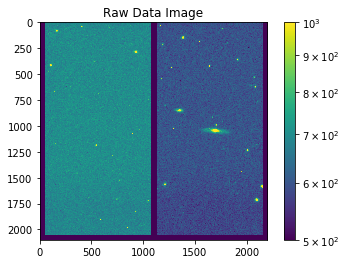

In [2]:
#Opening the raw image fits data file
raw = 'GROND_rband.246_0006.fits'
image = ImageData(filen=raw)
#Plotting the fits file
pylab.imshow(image.raw,vmin=500,vmax=1000,norm=LogNorm())
pylab.colorbar() #colour shows visually how many counts per pixel (ie the flux)
pylab.title('Raw Data Image')

Text(0.5,1,'Combined CCD image')

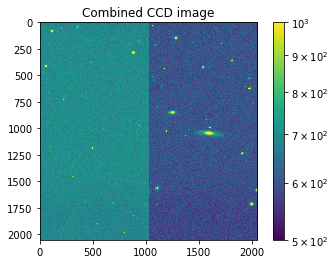

In [3]:
#Cropping the image to remove borders
pylab.imshow(image.rawtrim,vmin=500,vmax=1000,norm=LogNorm())
pylab.colorbar()
pylab.title('Combined CCD image')

Text(0.5,1,'Image Bias')

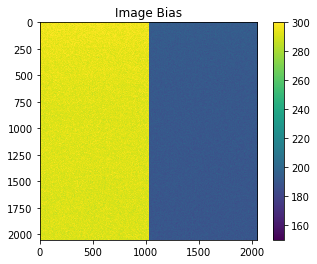

In [4]:
#Read in bias frame
bias = 'bias_r.fits' 
image.readbias(bias)

# Let's plot the bias frame to see what it looks like
pylab.imshow(image.bias,vmin=150,vmax=300)
pylab.colorbar()
pylab.title('Image Bias')

Text(0.5,1,'Chip 1 pixel-pixel variation')

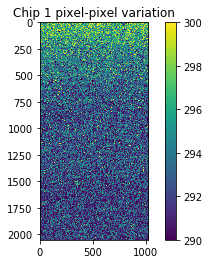

In [5]:
#Chip 1, low-level pixel to pixel level variation
pylab.imshow(image.bias[:,:-1023],vmin=290,vmax=300)
pylab.colorbar()
pylab.title('Chip 1 pixel-pixel variation')

Text(0,0.5,'Number of pixels')

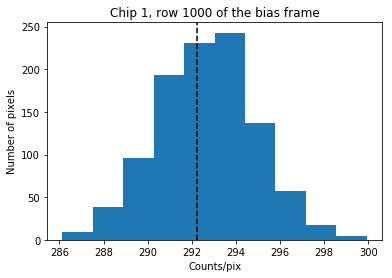

In [6]:
# Plotting a histogram of the counts/pix along row 1000 for chip 1
pylab.hist(image.bias[1000:1001,:-1023].ravel())
pylab.plot([image.chip1_bl,image.chip1_bl],[0,255],ls='--',c='k')
pylab.ylim([0,255])
pylab.title('Chip 1, row 1000 of the bias frame')
pylab.xlabel('Counts/pix')
pylab.ylabel('Number of pixels')

Text(0,0.5,'Number of pixels')

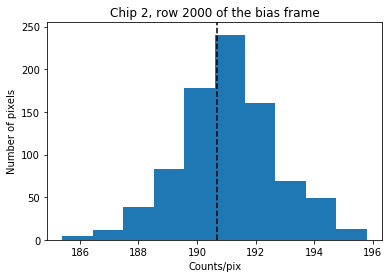

In [7]:
# First let's plot a histogram of the counts/pix along row 1000 for chip 2
pylab.hist(image.bias[1000:1001,1200:].ravel())
pylab.plot([image.chip2_bl,image.chip2_bl],[0,300],ls='--',c='k')
pylab.ylim([0,255])
pylab.title('Chip 2, row 2000 of the bias frame')
pylab.xlabel('Counts/pix')
pylab.ylabel('Number of pixels')

Text(0.5,1,'Raw Image with Subtracted Bias')

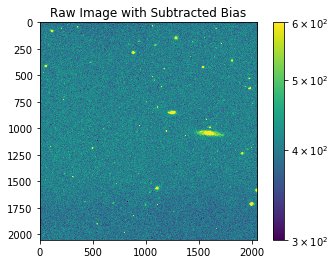

In [8]:
#Subtracting of image bias from the raw data image
image.bias_subtract()

#Showing new bias subtraction image
pylab.imshow(image.biassub,vmin=300,vmax=600,norm=LogNorm())
pylab.colorbar()
pylab.title('Raw Image with Subtracted Bias')

Text(0.5,1,'Flat Field Image')

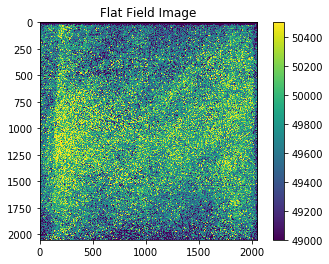

In [9]:
#Data reduction
flat = 'flat_r.fits'
image.readflat(flat) #readsremoves artifacting from pixel to pixel sensitivity variations
#Showing the flat-field frame
pylab.imshow(image.flat,vmin=49000,vmax=50500)
pylab.colorbar()
pylab.title('Flat Field Image')

Text(0.5,1,'Normalised Flat Field Image')

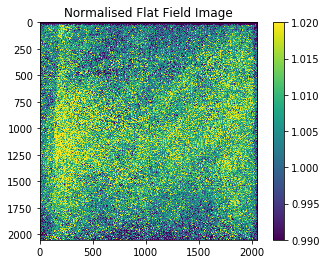

In [10]:
# Normalisation of the flat field frame such that the counts = 1
image.flat = image.flat/np.mean(image.flat)

#Normalised flat field frame
pylab.imshow(image.flat,vmin=0.99,vmax=1.02)
pylab.colorbar()
pylab.title('Normalised Flat Field Image')

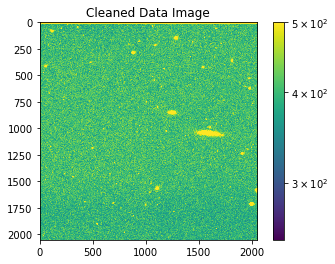

In [11]:
# Let's now flat-field our data image
image.flatfield()

# Final reduced data is bias-subtracted and flat-fielded 
# Showing reduced data fits image
pylab.imshow(image.red,vmin=250,vmax=500,norm=LogNorm())
pylab.colorbar()
pylab.title('Cleaned Data Image')
#Saving reduced image as a .fits file
image.savefits(image.red,'my_reddata')

### 2.2 GROND dataset - Star flux and magnitude caluclations 

The area over which the stars flux is measured is: 1257
The total star flux (not ajusted for background noise) is:  804313 counts
The area over which the standard stars flux is measured is: 1257
The total standard star flux (not ajusted for background noise) is:  631952 counts
The area over which background noise is calculated is: 31416
The total background noise in this area is:  12679688 counts
Background noise per pixel is: 404 counts
The flux emitted by the star (noise adjusted) is:  297125 +/- 9e+02 counts
The flux emitted by the standard star (noise adjusted) is:  124765 +/- 9e+02 counts
The magnitude of the zero point is: 48.84
The magnitude of the star is:  17.33 +/- 0.62


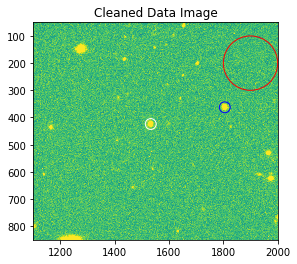

In [12]:
def star_photometry():
    
    

    #CALCULATING FLUX AND MAGNITUDE OF A STAR FROM GROND

    #Defining the star area and finding its flux
    xpos = 1533 #x-position of object in image being measured
    ypos = 424  #y-position of object in image being measured
    srcrad = 20 #radius over which to measure the object's flux
    starsky = photutils.CircularAperture((xpos, ypos), srcrad) #plots circular aperture over image
    star_circle = aperture_photometry(image.red, starsky) #calculates the flux in a given area for a fits file
    starflux = float(star_circle['aperture_sum']) #converts the flux output to a float value for easy printing
    print ('The area over which the stars flux is measured is: ' "{:.0f}".format(float(starsky.area())))
    print ('The total star flux (not ajusted for background noise) is: ', "{:.0f}".format(starflux), 'counts')


    #Defining the standard star area and finding its flux
    std_star_xpos=1805.3 #x-position of object in image being measured
    std_star_ypos=362.6  #y-position of object in image being measured
    std_starrad = 20 #radius over which to measure the object's flux
    std_starsky = photutils.CircularAperture((std_star_xpos, std_star_ypos), std_starrad)
    std_star_circle = aperture_photometry(image.red, std_starsky)
    std_starflux = float(std_star_circle['aperture_sum'])
    print ('The area over which the standard stars flux is measured is: ' "{:.0f}".format(float(std_starsky.area())))
    print ('The total standard star flux (not ajusted for background noise) is: ', "{:.0f}".format(std_starflux), 'counts')


    #Defining the background sky area and finding its flux 
    xpos1 = 1900 #x-position of noise
    ypos1 = 200  #y-position of noise
    nrad  = 100  #radius over which to calculate background noise
    awaysky = photutils.CircularAperture((xpos1, ypos1), nrad)
    sky_circle = aperture_photometry(image.red, awaysky)
    skyflux = float(sky_circle['aperture_sum'])
    print ('The area over which background noise is calculated is: ' "{:.0f}".format(float(awaysky.area())))
    print ('The total background noise in this area is: ', "{:.0f}".format(skyflux), 'counts')


    #plotting the measuiring radii onto the image
    pylab.xlim(1100,2000)
    pylab.ylim(850,50)
    pylab.imshow(image.red,vmin=250,vmax=500,norm=LogNorm())
    pylab.title('Cleaned Data Image')
    starsky.plot(ec='white') #the star measuring circle is plotted in white
    awaysky.plot(ec='red')   #the background noise measuring circle is plotted in red
    std_starsky.plot(ec='blue') #the standard star measuring circle is plotted in white

    #Calculating flux of just the star
    #1st calculate background noise per pixel

    f1 = float(sky_circle['aperture_sum'])/awaysky.area() #Skycircle flux per pixel for away sky dimensions
    f2 = f1*starsky.area() #background noise per pixel multiplied by pixel area for star

    #Star flux is the flux measured in starsky - (background pixel noise per area * starsky area)
    print ('Background noise per pixel is:', "{:.0f}".format(f1), 'counts')
    starflux_adjusted = float(star_circle['aperture_sum']) - f1*starsky.area()

    std_error = np.sqrt(sky_circle['aperture_sum']/(float(awaysky.area()))) #calculating standard error
    sigma = np.sqrt(star_circle['aperture_sum'] + std_error**2)
    sigmaf = float(sigma)
    print ('The flux emitted by the star (noise adjusted) is: ', "{:.0f}".format(starflux_adjusted),'+/-', "{:.1g}".format(sigmaf),'counts')


    #Calculating flux of just the standard star
    #1st calculate background noise per pixel

    std_f1 = float(sky_circle['aperture_sum'])/awaysky.area() #Skycircle flux per pixel for away sky dimensions
    std_f2 = f1*std_starsky.area() #background noise per pixel multiplied by pixel area for star

    #Standard Star flux is the flux measured in std_starsky - (background pixel noise per area * std_starsky area)
    std_starflux_adjusted = float(std_star_circle['aperture_sum']) - f1*std_starsky.area()
    std_sigma = np.sqrt(std_star_circle['aperture_sum'] + std_error**2) 
    std_sigmaf = float(std_sigma)
    print ('The flux emitted by the standard star (noise adjusted) is: ', "{:.0f}".format(std_starflux_adjusted),'+/-', "{:.1g}".format(sigmaf),'counts')

    #Zeropoint calculation
    #Zeropoint is the magnitude that corresponds to a source with a flux of 1 cts/sec
    zeropoint =  19.50 + 2.5*np.log((std_starflux_adjusted))
    print ('The magnitude of the zero point is: ' "{:.4g}".format(zeropoint))
    
    #calculating the magnitude of the measured star
    Mag_star = zeropoint - 2.5*np.log(starflux_adjusted)
    Mag_star_err = Mag_star*np.sqrt((sigmaf/float(star_circle['aperture_sum']))**2 + (std_sigmaf/float(std_star_circle['aperture_sum'])))
    print ('The magnitude of the star is: ', "{:.4g}".format(Mag_star), '+/-', "{:.2g}".format(Mag_star_err))

    
star_photometry()

### 2.2 Data Reduction - Kepler Lightcurve 

Two sets of data were provided by Kepler, each corresponding to separate stellar systems. For the purposes of this paper, only the dataset for - 'Object 1' will be considered. This dataset contains continuous flux and time observations of the designated star system. As such, lightcurves were constructed to identify the transits of exoplanets. The data was provided in the form of many separate lightcurve files, which are listed below.

Before undertaking analysis of the entire dataset listed above, a subset of the data was initially looked at. The subset was plotted with on a graph of time in days against flux. Looking at the first graph below we can see that the stars flux randomly fluctuates with time between around 41500 and 41700 counts. However, we can clearly see large periodic dips in the flux emitted by the star over a short amount of time. These dips in the lightcurve are attributed to the transiting of an extrasolar planet in front of the face of the star. Now that we have observed a planet transiting the face of the star in the plane of observation, we can start to data analysis on the object to calculate its period, radius, semi major axis and density and whether or not the planet is habitable.

Filename: Data/Object1lc/kplr1_1.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      59   ()      
  1  LIGHTCURVE    1 BinTableHDU    162   4370R x 20C   [D, E, J, E, E, E, E, E, E, J, D, E, D, E, D, E, D, E, E, E]   
  2  APERTURE      1 ImageHDU        49   (6, 6)   int32   


XTENSION= 'BINTABLE'           / marks the beginning of a new HDU               
BITPIX  =                    8 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                  100 / length of first array dimension                
NAXIS2  =                 4370 / length of second array dimension               
PCOUNT  =                    0 / group parameter count (not used)               
GCOUNT  =                    1 / group count (not used)                         
TFIELDS =                   20 / number of table fields                         
TTYPE1  = 'TIME    '           / column title: data time stamps                 
TFORM1  = 'D       '           / column format: 64-bit floating point           
TUNIT1  = 'BJD - 2454833'      / column units: barycenter corrected JD          
TDISP1  = 'D14.7   '           / column display format                          
TTYPE2  = 'TIMECORR'        

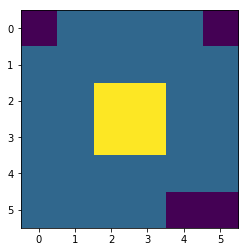

In [13]:
#Fits files are open like this:
object_1 = fits.open('Data/Object%slc/kplr%s_1.fits'%(mykepler, mykepler))
object_1.info()

#the data in the extension can be stored like this:
object_1[0].data
#the first extension is empty, it just has the information

#The last extension holds a small image of the source:
object_1[2].header
pylab.imshow(object_1[2].data)

#lets have a look at the second extension
object_1[1]
#This is a table extension

#Here the beginning has a description of columns in the table, including the units
object_1[1].header

Text(0,0.5,'Flux')

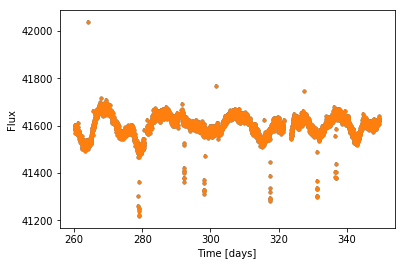

In [14]:
#Plotting the lightcurves as a function of time and flux:
#This plots the barycentre time and flux in e/s
#Measurements errors are also included, you can plot them as follows

#Plotting time and flux to see how the system behaves over time and if there are any transits
pylab.plot(object_1[1].data['TIME'], object_1[1].data['PDCSAP_FLUX'], ls='None', marker='.')
pylab.errorbar(object_1[1].data['TIME'], object_1[1].data['PDCSAP_FLUX'], object_1[1].data['PDCSAP_FLUX_ERR'], ls='None', marker='.')
pylab.xlabel('Time [days]')
pylab.ylabel('Flux')
#The error bars are small, so we need to zoom in to see them


Text(0,0.5,'Flux')

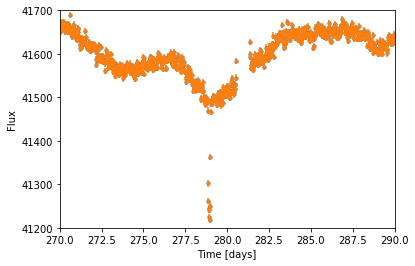

In [15]:
#Plotting the lightcurve again
pylab.plot(object_1[1].data['TIME'], object_1[1].data['PDCSAP_FLUX'], ls='None', marker='.')

#Measurements errors are also included, you can plot them as follows
pylab.errorbar(object_1[1].data['TIME'], object_1[1].data['PDCSAP_FLUX'], object_1[1].data['PDCSAP_FLUX_ERR'], ls='None', marker='.')

#We'll need to zoom in to see them:
#Zoom in over a transit
pylab.xlim(270, 290)
pylab.ylim(41200, 41700)
pylab.xlabel('Time [days]')
pylab.ylabel('Flux')

for lcfile in glob.glob('Data/Object%slc/kplr*.fits' %(mykepler)):
    tmp = fits.open(lcfile)
    tmptime = (tmp[1].data['TIME'])
    tmpflux = (tmp[1].data['PDCSAP_FLUX'])
    tmperror = (tmp[1].data['PDCSAP_FLUX_ERR'])
    pylab.plot(tmptime, tmpflux, c='k')

Starting with just the one fits file, the data reduction techniques were tested, these techniques were then applied to the enitre Kepler data set.

When inspecting the data, there are places that are missing data or filled with values that don't make sense, therefore the data needs to be reduced. It is common practice to fill missing data points with inf values and nan value. Some functions in the ‘numpy’ and ‘scipy’ python libraries don't work when there and inf/nan values in the array, so we need to apply a filter to remove them. Applying an inf/nan mask will make it such that the when the array is passed into functions the inf/nan points will be passed over by the function.



In [16]:
#Numpy/Scipy functions do not work with Inf and Nan values
#Lets create some new variables to which we can apply an Inf/Nan filter to

t_nofilter = object_1[1].data['TIME'] #time column of fits file
f_nofilter = object_1[1].data['PDCSAP_FLUX'] #point source flux data from the fits file
e_nofilter = object_1[1].data['PDCSAP_FLUX_ERR'] #point source flux error from the fits file

#Applying a mask filter to remove nan points

nonan = ~np.isnan(f_nofilter)
t1 = t_nofilter[nonan]
f1 = f_nofilter[nonan]
e1 = e_nofilter[nonan]

Now that our data has been cleaned of these inf/nan data points. We can normalise the flux emitted by the star. This will give us a value for the average flux emitted by the star. We have three options of filters to use, a Savtisky-Galoy function, a spline filter or and median filter. The best filter is the one that fits lightcurve of the star whilst ignoring the transits of the planet. At low kernel sizes the Savitsky-Galoy and spline filter both matched the lightcurve of the star well, but they could not exclude the exoplanet dips. In order to exclude the dips from the data, a high kernel size had to be used with both filters, this outputted a normalisation lightcurve that had large fluctuations in the stars flux. The spline filter is also a demanding function to execute and takes a long time to complete. The median filter was preferred over the other two filter functions as it was able to match the lightcurve and avoid the planet transits whilst also being relatively quick to execute.  

The medium filter works by finding the median value between two limits in the data. It then moves in the positive x direction by the difference between the two limits. The function iterates over the whole array, creating a median point value for every iteration. The limits correspond to a kernel size, i.e. the amount of data points over which the median is determined. The filter outputs these values into an array which can then be used to normalise the data by dividing the flux array by this array. The kernel size was chosen to be 51, this was chosen by looking at the normalisation output graph and trying different values to get the flattest normalisation lightcurve with the strongest planet dips.

We now have a flat lightcurve of fluxes with only dips from exoplanet transits. Another use of normalising the curve is it shows us the percentage dip in flux caused by the exoplanet as a decimal value. 

The normalised lightcurve is important, not just because it removes the star activity, but because in order to create a periodogram for the star, we need a flat lightcurve. The periodogram will pick up the random flux fluctuations and plot them as periods, we don't want this in our data because this will lead to false conclusions on the number of exoplanets in the extrasolar system. Therefore, by using a normalised lightcurve most random flux variations are removed and the periodogram will be easier to interpret. 


Text(0,0.5,'Flux')

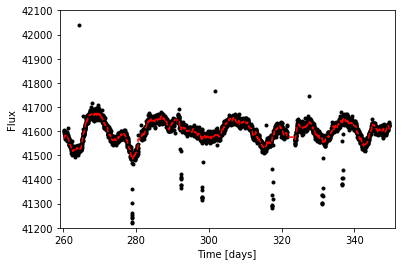

In [17]:
#kernel_size is the size of the window over which the median is calculated 

medfil = medfilt(f1, kernel_size=21) #talk about why i chose median filter and the kernel size

pylab.plot(t1, f1, c='k', ls='None', marker='.', label='Data')
pylab.plot(t1, medfil, ls='--', c='r', label='Median Filter')
pylab.xlim(259, 351)
pylab.ylim(41200, 42100)
pylab.xlabel('Time [days]')
pylab.ylabel('Flux')

Text(0,0.5,'Normalised Flux')

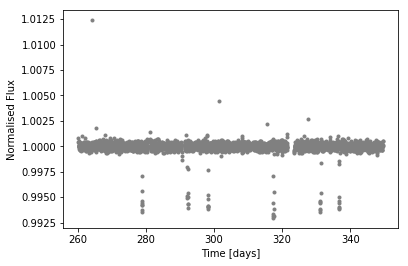

In [18]:
#plotting normalised median

flux_normalised = f1/medfil #Normalise flux by dividing by the median filter
flux_error_normalised = e1/medfil #Normalise flux error by dividing by the median filter

pylab.plot(t1, flux_normalised, ls='None', marker='.', c='grey', label='Data')
pylab.xlabel('Time [days]')
pylab.ylabel('Normalised Flux')


### 3. Results - Modelling of Kepler lightcurve

Now that the data has been reduced, the periods of any exoplanets orbiting around the host star can be determined.  Each periodic dip in the flux in the lightcurve corresponds to an exoplanet transiting the face of the star.  Therefore, by applying the lombscargle periodogram function to the lightcurve data set, one would expect an output of the periods in days of each transiting planet. The lombscargle function acts similarly to a Fourier transform from the time domain to the frequency domain. The first application of the function produces a plot, but there is a high level of aliasing. This was reduced by reapplying the lombscargle function a second time to the data. This gave a plot of lots of periods, inspecting the graph one can see the periods of two planets orbiting the star. Planet 1 has a period of 19.237 days and Planet 2 has a period of 38.98 days. These periods are displayed clearly by the black vertical lines. A second transit from Planet 1 can be seen next to the period of Planet 2. There is still aliasing in the plot, but it occurs at periodic intervals, the second planet is distinguished from the low-level aliasing because it does not follow the same pattern behaviours as the low-level peaks. 

Text(0.5,0,'Time (days)')

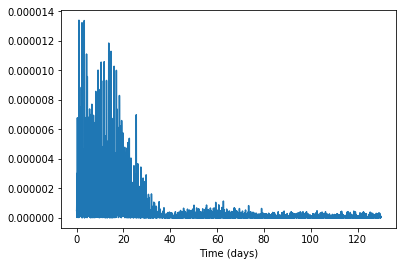

In [19]:
#Finding the period of exoplanets using periodgrams

freq = np.linspace(1/130,130, 13000) #defining the minimum amd maximum sampling time in the frequency space

lomb = scipy.signal.lombscargle(t1, flux_normalised, freq, precenter= True) 

#lomb is the first transform from the time domain to the frequency domain

pylab.plot(freq, lomb)
pyplot.xlabel('Time (days)')


Text(0.5,0,'Time (days)')

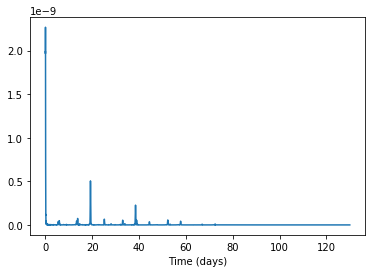

In [20]:
#Second application of the Lomscargle function gives the periods

lomb_1 = scipy.signal.lombscargle(freq, lomb, freq, precenter=True)
pylab.plot(freq, lomb_1)
pyplot.xlabel('Time (days)')


Text(0.5,0,'Time (days)')

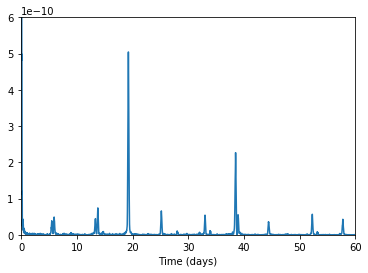

In [21]:
pylab.plot(freq, lomb_1)
pylab.xlim(-0.10,60)
pylab.ylim(0.0,0.0000000006)
pyplot.xlabel('Time (days)')

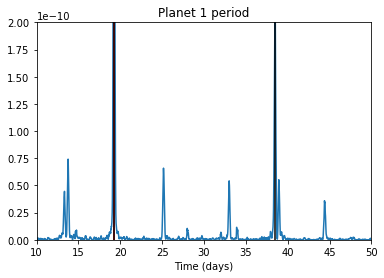

In [22]:
pylab.plot(freq, lomb_1)
pylab.xlim(10,50)
pylab.ylim(0.0,0.0000000002)
pyplot.xlabel('Time (days)')
pyplot.title('Planet 1 period')
actper = 19.237 ## the actual period
pylab.axvline(actper, c='r') ## indicating the actual period
for i in [1, 2]:
    pylab.axvline(actper*i, c='k')
    
    

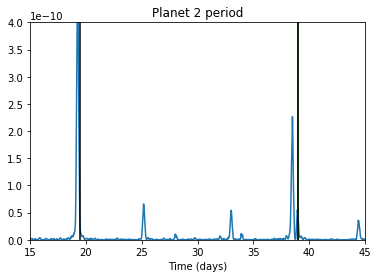

In [23]:
pylab.plot(freq, lomb_1)
pylab.xlim(15,45)
pylab.ylim(0.0,0.0000000004)
pyplot.xlabel('Time (days)')
pyplot.title('Planet 2 period')
#actper = 19.237 ## the actual period
#pylab.axvline(actper, c='y') ## indicating the actual period
#for i in [1, 1.5, 2, 2.5, 3.0]:
#    pylab.axvline(actper*i, c='k')
    
actper1 = 38.98 ## the actual period
pylab.axvline(actper1, c='g') ## indicating the actual period
for i in [0.5, 1.00, 1.5, 2.0]:
    pylab.axvline(actper1*i, c='k')

Knowing the periods of the planets from one lightcurve file, one can start working with the entire list of lightcurves provided by the Kepler space telescope. The program starts by entering the directory of where the lightcurve data is saved. A full plot of all the lightcurves is then made. We can clearly see that there is gap between each sampling taken by Kepler. We also see a large range of flux values for each lightcurve file. Each individual lightcurve needs to be normalised and then combined into one shorter lightcurve. The purpose of folding the data, i.e. superimposing each lightcurve on top of one another, is that it makes a stronger trend in the transits of the exoplanets. First the data was normalised using the same median filter as before and then saved to a new ‘.csv’ file so that it could be folded. A graphical output of the normalised unfolded data can be seen below. As one can see the unfolded lightcurve is 1600 days long and features many transits. The program folds the normalised data into a shorter phase diagram, with phase from 1 to 3. We can see from this phase diagram a strong trend each time an exoplanet transits the star.

In [24]:
## Working over the entire data set
glob.glob('Data/Object%slc/kplr*.fits'%(mykepler)) #Lists all the lightcurve files .fits in the directory

['Data/Object1lc/kplr1_4.fits',
 'Data/Object1lc/kplr1_14.fits',
 'Data/Object1lc/kplr1_7.fits',
 'Data/Object1lc/kplr1_11.fits',
 'Data/Object1lc/kplr1_1.fits',
 'Data/Object1lc/kplr1_3.fits',
 'Data/Object1lc/kplr1_5.fits',
 'Data/Object1lc/kplr1_2.fits',
 'Data/Object1lc/kplr1_17.fits',
 'Data/Object1lc/kplr1_16.fits',
 'Data/Object1lc/kplr1_8.fits',
 'Data/Object1lc/kplr1_6.fits',
 'Data/Object1lc/kplr1_12.fits',
 'Data/Object1lc/kplr1_13.fits',
 'Data/Object1lc/kplr1_10.fits',
 'Data/Object1lc/kplr1_9.fits',
 'Data/Object1lc/kplr1_15.fits']

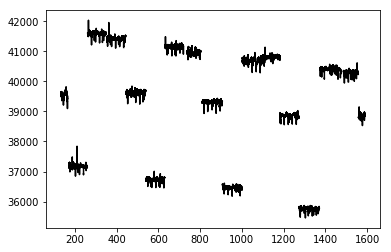

In [25]:
#Lets plot all our lightcurves together onto one graph

for lcfile in glob.glob('Data/Object%slc/kplr*.fits' %(mykepler)):
    tmp = fits.open(lcfile)
    tmptime = (tmp[1].data['TIME'])
    tmpflux = (tmp[1].data['PDCSAP_FLUX'])
    tmperror = (tmp[1].data['PDCSAP_FLUX_ERR'])
    pylab.plot(tmptime, tmpflux, c='k')

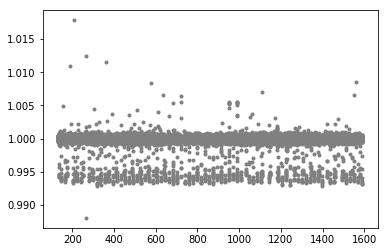

In [26]:
#Applying the same data reduction techniques used on one lightcurve
#to the entire lightcurve dataset

full_dataset_time=[]    # define new set arrays for our entire dataset (stop conflicting variables)
full_dataset_flux=[]    
full_dataset_flux_error=[]

#Opening and reading all the fits files in the object 1 directory

for lcfile in glob.glob('Data/Object%slc/kplr*.fits' %(mykepler)): 
    tmp = fits.open(lcfile)
    t = (tmp[1].data['TIME'])
    full_flux = (tmp[1].data['PDCSAP_FLUX'])
    error = (tmp[1].data['PDCSAP_FLUX_ERR'])
    
    
#Plotting a normalised lightcurve for all the fits files

    medfilter = medfilt(full_flux, kernel_size = 21) #Calling the same median filter function as before
    normalised_flux = full_flux/medfilter            #Normalise flux error by dividing by the median filter as before
    normalised_error = error/medfilter               #Normalise flux error by dividing by the median filter as before
    
    pylab.plot(t, normalised_flux, ls='None', marker='.', c='grey', label='Data') #plots the normalised fits data
    
#Adds the noramlised fits data onto the end of each array
    
    full_dataset_time.extend(t)
    full_dataset_flux.extend(normalised_flux)
    full_dataset_flux_error.extend(normalised_error)

In [27]:
#In order to work with the normalised dataset, we need to save it.
#Saves the arrays to a new file
#We'll first need to write our data to file.

np.savetxt('normalised_dataset.csv', np.array([t, normalised_flux, normalised_error]).transpose(), header='#JD, mag, error', delimiter=',')

In [28]:
#We want to combine all the transits together to get a stronger data trend
#To do this we apply a fold to the dataset so that they overlap

def fold_lightcurve(filename, period, *args, **kwargs):
    obj_name = kwargs.get('obj_name', None)
    outdata = kwargs.get('output_file', 'folded_lc_data.csv')
    plotname = kwargs.get('plot_file', 'folded_lc.pdf')
    
    ## Read in the data. Should be comma separated, header row (if present) should have # at the start.
    data = pd.read_csv(filename, usecols=[0,1,2], names=('JD', 'mag', 'error'), comment='#')
    if len(data.columns) < 3:
        print("File format should be \n\
              (M)JD, magnitude, uncertainty\n")
        exit(1)
    ## Folding the lightcurve:
    ## Phase = JD/period - floor(JD/period)
    ## The floor function is there to make sure that the phase is between 0 and 1.
    
    data['Phase'] = data.apply(lambda x: ((x.JD/ period) - np.floor(x.JD / period)), axis=1)
    
      
    ## Now make the plot
    
    pyplot.clf()
    pyplot.figure(figsize=(10,5))
    
    ## concatenating the arrays to make phase -> 0 - 3
    ## This makes it easier to see if periodic lightcurves join up as expected
    
    phase_long = np.concatenate((data.Phase, data.Phase + 1.0, data.Phase + 2.0))
    mag_long = np.concatenate((data.mag, data.mag, data.mag))
    err_long = np.concatenate((data.error, data.error, data.error))
    
    pyplot.errorbar(phase_long, mag_long, yerr=err_long, marker='o', ls='None', zorder=4, label='_nolegend_', mec='Grey')
    ## Inverting the y axis because magnitudes
    #pyplot.gca().invert_yaxis()
    
    pyplot.xlabel('Phase ($\phi$)')
    pyplot.ylabel('Magnitude')
    
    ## making the plot title to include object and period. 
    ## If no object name given in kwargs then title is just period
    if obj_name != None:
        namestring = str(obj_name) + ', '
    else:
        namestring = ''
    titletext = namestring + 'P = ' + str(np.around(period, decimals=4)) + 'd'
    pyplot.suptitle(titletext)
    
    pyplot.savefig(plotname)
    
    ## Printing the phased data to a csv file.
    ## If filename not given in fold_lightcurve arguments default filename is folded_lc_data.csv
    
    data.to_csv(outdata, header=True, index=False, sep=',')

    
    return data

,JD,mag,error,Phase
0,1001.208319,NaN,NaN,0.045970
1,1001.228752,1.000680,0.000174,0.047032
2,1001.249184,1.000214,0.000174,0.048094
3,1001.269617,0.999926,0.000174,0.049156
4,1001.290050,0.999382,0.000174,0.050218
5,1001.310483,0.999693,0.000174,0.051280
6,1001.330916,0.999686,0.000174,0.052343
7,1001.351348,0.999767,0.000174,0.053405
8,1001.371781,0.999928,0.000174,0.054467
9,1001.392214,1.000000,0.000174,0.055529


<Figure size 432x288 with 0 Axes>

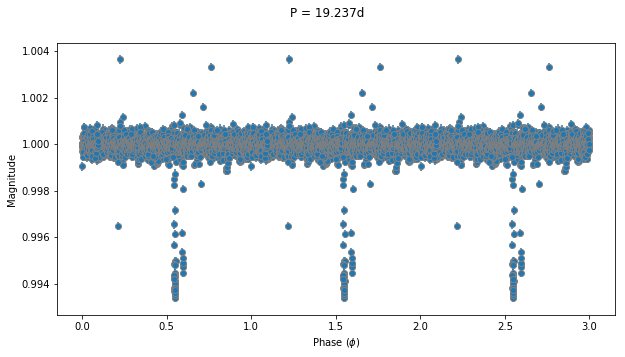

In [29]:
#Lets try folding on the period we found from the single lightcurve
fold_lightcurve('normalised_dataset.csv', 19.237)
#Phase goes from 0-1, we can clear see a nicely folded transit for this phase

(0, 3)

<Figure size 432x288 with 0 Axes>

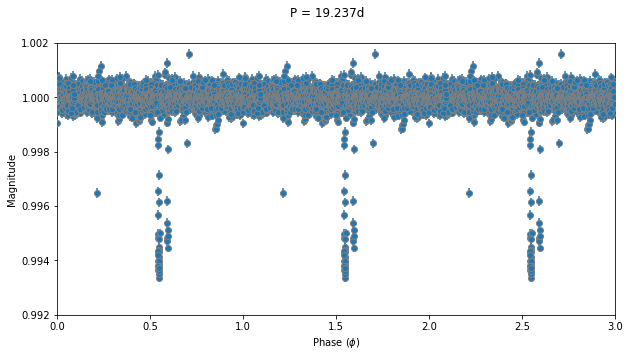

In [30]:
fold_lightcurve('normalised_dataset.csv', 19.237)
pylab.ylim(0.992,1.002)
pylab.xlim(0,3)


(0.53, 0.61)

<Figure size 432x288 with 0 Axes>

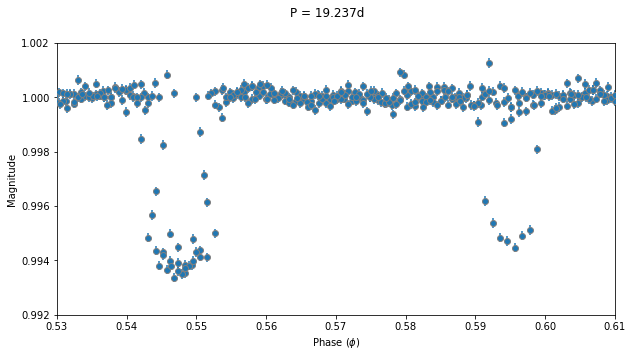

In [31]:
fold_lightcurve('normalised_dataset.csv', 19.237)
pylab.ylim(0.992,1.002)
pylab.xlim(0.53,0.61)


In order to determine the depth of the transit caused by each exoplanet, a parametric model needs to be fit to the lightcurve. Below one can see how a basic function was fit to the folded normalised data. The program uses the ‘curve_fit’ function with a function of, n, parameters defined by the user. The function also sets limits on the where to begin the fit on the data. One limitation of the function is that it doesn't account for limb darkening and therefore the parametric function won't fit to the bottom of the transit. However, for the case of this paper, a rudimentary calculation of the depth will suffice. Using the transit depth one can determine the planets radius.

In [32]:
#Modelling the lightcurve of Planet 1
transits = pd.read_csv('folded_lc_data.csv', error_bad_lines=False) #reads the normalised dataset
nanmask = ~np.isnan(Y)                                               #flux nan mask
Y = transits['mag'].values                                          #New variable definitions for the plotting function
X = transits['Phase'].values
yerror = transits['error'].values                   

#Defining the functions operating coniditions(baseline, lower limit, upper limit)

def func(X, a, b, fmax, fmin):
    
    y= [] 
    for x in X: 
        if x<a:
            y.append(fmax)
        if x>a and x<b:
            y.append(fmin)
        if x>b:
            y.append(fmax)
    return y

#Findind the transit depth function

popt1, pcov1 = curve_fit(func, X[nanmask], Y[nanmask], p0 = [0.543, 0.552, 1.00, 0.992]) # using curve_fit function
delta_flux_1= popt1[2]-popt1[3]                                                            # calculating the change in flux



NameError: name 'Y' is not defined

In [ ]:
pylab.scatter(X, Y)
xdata = np.linspace(min(X), max(X), 1000)
pylab.plot(xdata, func(xdata, *popt1), 'g', label='fit: a=%5.3f, b=%5.3f, c=%5.3f, d=%5.3f' % tuple(popt1))
pylab.ylim(0.992, 1.002)
pylab.xlim(0.525,0.575)
pylab.title('Planet 1 transit depth')
print('Planet 1 transit depth is: ', "%.6f" % delta_flux_1)    # printing the value of the change in flux


In [ ]:
#Modelling the lightcurve of Planet 2

popt, pcov2 = curve_fit(func, X[nanmask], Y[nanmask], p0 = [0.59, 0.60, 1.00, 0.992])

pylab.scatter(X, Y)
xdata = np.linspace(min(X), max(X), 1000)

pylab.plot(xdata, func(xdata, *popt), 'g', label='fit: a=%5.3f, b=%5.3f, c=%5.3f, d=%5.3f' % tuple(popt))
pylab.title('Planet 2 transit dept')
pylab.ylim(0.992, 1.002)
pylab.xlim(0.585,0.605)





Both of the curve_fit functions produce a poor fits to the data. The function fails for Planet 1 to reach the bottom of the transit because of the limb darkening effect. Limb darkening occurs when a planet starts or ends the transit. The effect is caused by only part of the planet blocking the stars flux. The function fails to find the correct transit depth for Planet 2 not because of the limb darkening effect, but rather because when the data is folded, due to the time gap between observation days the transits appears in different places. This has the effect of shifting some of the transits out of place. It can clearly be seen that there has been data shifted across to where the transit happens for Planet 2 from the figure titled 'Planet 2 transit depth.' 
Different function parameters were tried but positive effect could be made to create a better fit for either of the lightcurves.

A better estimate to the transit depth can be estimated by reading off the graph where the average depth point is for each transit. For Planet 1, the transit depth is estimated to be 0.006 +/- 0.001 and for Planet 2, 0.005 +/- 0.001. The uncertainty for these values can be read off from the graph as half the range of reasonable values that the transit depth could take. For Planet 1 the range is between 0.993 to 0.995 and for Planet 2 0.994 to 0.996.

Knowing an estimate for the transit depths, the radius of the planets can now be calculated using equation 2. Uncertainty on the radius was calculated from the percentage uncertainty on the read-out measurements of the transit depths for each exoplanet. The semi major axis and densities of the planets were then derived from the calculated radii. The mass of the exoplanets was provided by the assessor, as was the stars mass and radius. The uncertainty for the semi major axis and densities of the exoplanets were derived from the uncertainty in the radii.


In [ ]:
#Astronomical constants required for further data analysis

day = 86400             #Number of seconds in one earth day
G = 6.67e-11            #The Gravitational constant
Au = 1.5e11             #One astronomical unit in metres

#Radii
R_Solar = 695e6         #Radius of the sun in metres
R_Jupiter = 699e5       #Radius of Jupiter in metres

#Masses
M_Solar = 1.989e30      #Mass of the sun in kg
M_Jupiter = 1.898e27    #Mass of Jupiter mass in kg
M_Planet_1 = 0.137 * M_Jupiter
M_Planet_2 = 0.227 * M_Jupiter

#Periods in seconds

P_Planet_1 = 19.237 * day
P_Planet_2 = 38.98 * day

#Densities
D_Jupiter = 1330         #Density of Jupiter, in units of kg/m^3

#Variables given by assessor
kepler_star_properties = [1.022*M_Solar, 0.958*R_Solar] 
#1st value is the mass in solar masses, 2nd is the stars radius in solar radii

In [ ]:
#Estimating the radius of each exoplanet in the Kepler star system

delta_flux_planet_1 = 1 - 0.994 #read off estimate of the change in flux for planet 1
delta_flux_planet_2 = 1 - 0.995 #read off estimate of the change in flux for planet 1

#Planet 1
radius_planet_1 = (np.sqrt(delta_flux_planet_1*(kepler_star_properties[1])**2)) / R_Jupiter  
radius_1_error  = 0.001/0.006 * radius_planet_1
print('The radius of Planet 1 is: ', "%.3f Jupiter radii" % radius_planet_1)
print('The uncertainty in the radius of Planet 1 is: ', "%.3f Jupiter radii" % radius_1_error)
 
#Planet 2
radius_planet_2 = (np.sqrt(delta_flux_planet_2*(kepler_star_properties[1])**2)) / R_Jupiter  
radius_2_error  = 0.001/0.005 * radius_planet_2
print('The radius of Planet 2 is: ', "%.3f Jupiter radii" % radius_planet_2)
print('The uncertainty in the radius of Planet 2 is: ', "%.3f Jupiter radii" % radius_2_error)



In [ ]:
#Estimating the semi-major axis for both planets using equation (3)
#Planet 1
semi_mjr_p1 =((((P_Planet_1**2)*G*(kepler_star_properties[0] + M_Planet_1))/(4*(np.pi**2)))**(1/3)) /Au 
semi_mjr_error1 = 2*(0.001/0.006) * semi_mjr_p1
print ('The semi-major axis of Planet 1, in Astronomical Units, is: ', "%.3f AU" % semi_mjr_p1)
print('The uncertainty in the semi major axis of Planet 1 is: ', "%.3f Jupiter radii" % semi_mjr_error1)

#Planet 2
semi_mjr_p2 = ((((P_Planet_2**2)*G*(kepler_star_properties[0] + M_Planet_2))/(4*(np.pi**2)))**(1/3))/Au 
semi_mjr_error2 = 2*(0.001/0.005) * semi_mjr_p2
print ('The semi-major axis of Planet 2, in Astronomical Units, is: ', "%.3f AU" % semi_mjr_p2)
print('The uncertainty in the semi major axis of Planet 2 is: ', "%.3f Jupiter radii" % semi_mjr_error2)

In [ ]:
#Calculating the planets densities
#Density  = planet mass / 4/3*pi*planet radius^3
#Planet 1
Density_Planet_1 = M_Planet_1 / ((4/3)*np.pi*(radius_planet_1*R_Jupiter)**3)
Density_Planet_1J = Density_Planet_1 / D_Jupiter
Density_error_1 = 3*(0.001/0.006) * Density_Planet_1
Density_error_1J = 3*(0.001/0.006) * Density_Planet_1J
print('The density of Planet 1 is: ', "%.3d kg/m^3" % Density_Planet_1, ' OR ', "%.3f Jupiter densities" % Density_Planet_1J)
print('The density uncertainty for Planet 1 is: ', "%.3d kg/m^3" % Density_error_1, ' OR ', "%.3f Jupiter densities" % Density_error_1J)

#Planet 2
Density_Planet_2 = M_Planet_2 / ((4/3)*np.pi*(radius_planet_2*R_Jupiter)**3)
Density_Planet_2J = Density_Planet_2 / D_Jupiter
Density_error_2 = 3*(0.001/0.005) * Density_Planet_2
Density_error_2J = 3*(0.001/0.005) * Density_Planet_2J
print('The density of Planet 2 is: ', "%.3d kg/m^3" % Density_Planet_2, ' OR ', "%.3f Jupiter densities" % Density_Planet_2J)
print('The density uncertainty for Planet 2 is: ', "%.3d kg/m^3" % Density_error_2, ' OR ', "%.3f Jupiter densities" % Density_error_2J)

In [ ]:


def conflevels(x,y,nbins=1,confints=[0.99,0.95,0.68]):
    # Make a 2d normed histogram
    if (nbins>1):
        H,xedges,yedges=np.histogram2d(x,y,bins=nbins,normed=True)
    else:
        H,xedges,yedges=np.histogram2d(x,y,normed=True)
        
    norm=H.sum()              # Find the norm of the sum
   
    contour1=0.99             # Set contour levels
    contour2=0.95
    contour3=0.68

    target1 = norm*contour1   # Set target levels as percentage of norm
    target2 = norm*contour2
    target3 = norm*contour3

    # Take histogram bin membership as proportional to likelihood - this is true when data comes from a Markovian process
    def objective(limit, target):
        w = np.where(H>limit)
        count = H[w]
        
        
        return count.sum() - target

    # Find levels by summing histogram to objective
    level1= optimize.bisect(objective, H.min(), H.max(), args=(target1,))
    level2= optimize.bisect(objective, H.min(), H.max(), args=(target2,))
    level3= optimize.bisect(objective, H.min(), H.max(), args=(target3,))

    # For nice contour shading with seaborn, define top level
    level4=H.max()
    levels=[level1,level2,level3]

    return levels



In [ ]:
masses = np.array([0.137, 0.227])   #Array containing Juptier masses of each planet
periods = np.array([19.237, 38.98]) #Array containing period in days of each planet

#Table is taken from the NASA exoplanet archive ICE Plotting tool of confirmed planets
#https://exoplanetarchive.ipac.caltech.edu/cgi-bin/IcePlotter/nph-icePlotInit?mode=demo&set=confirmed
#accessed 19/12/2019

table1 = np.loadtxt('Data/plot.tbl.txt', skiprows=3)

levels = conflevels(np.log10(table1[:,1]),np.log10(table1[:,2]))

pylab.xlabel(r'Orbital period (days)',fontsize=14)
pylab.ylabel(r'Mass (Jupiter mass)',fontsize=14)

pylab.scatter(np.log10(table1[:,1]), np.log10(table1[:,2]), alpha = 0.4, color='m') # alpha determines transparency
sns.kdeplot(np.log10(table1[:,1]),np.log10(table1[:,2]),n_levels=levels)

pylab.scatter(np.log10(periods), np.log10(masses), color = 'black', alpha = 0.7)



### 4. Discussion

The paper had the goal of finding planets in an extrasolar system and to determine whether the planets are habitable. Two planets were found in the Kepler star system of periods 19.237 (Planet 1) and 38.98 (Planet 2). The radii, semi-major axes and densities were also found for both planets. For Planet 1 they were; 0.738 +/-0.123 Jupiter radii, 0.141 +/- 0.047 AU and 0.340 +/-0.170 Jupiter's density. For Planet 2 they were; 0.674 +/- 0.135 Jupiter radii, 0.226 +/- 0.226 Au and 0.741 +/- 0.371 Jupiter's density. Planet 2 is a smaller and denser than planet one and orbits the host star further out than Planet 1.

Both the discovered planets have significantly large fractions of Jupiter’s radius. The largest known rocky planets have radii of approximately two earth radii (0.2 in Jupiter radii). Both exoplanets had radii over 3 times this value. Therefore, we can rule out with certainty that the planets can’t be rocky bodies. The masses and densities of the exoplanets are too low to suggest them being a migrating Hot Jupiter type of planet. Both planets have densities indicative of a low-density gas giants, such a Saturn. Knowing this and looking at the contour plot of the mass against the orbital period. We can see that both our planets fall just outside the accretion planet formation regime (the two points highlighted in black). We can therefore conclude that both Planet 1 and Planet 2 are low-density gas giant planets formed by accretion. Due to the being made up of primarily gas, both exoplanets would not be habitable. Furthermore, the exoplanet’s orbits are very close to the host star. The host star is a G-type main sequence star. Therefore, one would expect that any planet that is not in an orbit of approximately 1 Au to be uninhabitable. By this same reasoning we can also rule that the planets will not be ice giants as they are too close to the host star for ice to remain solid.  

IIt is clear to see that this extrasolar system is not akin to our own. It is dominated by gaseous planets, in low orbits travelling around the host star at high velocities. Our own solar system does not have any gaseous planets within 5 Au of the sun whereas in this system both planets orbit within 0.25 Au. We can also conclude that in the early stages of the extrasolar systems life, there must have been of gas and dust orbiting near to the star because lots of gas and dust is required for gas giants to form by accretion.

Further measurements of spectroscopy could be carried out on these two exoplanets to determine their atmospheric composition. This would allow for a greater understanding of composition of the planets mass. This could give more insight into how the exoplanets formed.

### 5. Summary

$\bullet$ Data reduction techniques were applied to the GROND dataset.

$\bullet$ The techniques demonstrated were bias-frame subtractions and flat fielding.

$\bullet$ An aperture photometry function was written to determine the magnitude of a star in the image.

$\bullet$ The function accounted for background noise in the image and found the uncertainties.

$\bullet$ The function calculated the magnitude of a star from the zero point in the image and a standard star 
of magnitude +19.5.

$\bullet$ The absolute magnitude was calculated to be +17.33 +/- 0.62.

$\bullet$ Data reduction techniques were applied to lightcurves from the Kepler Space telescope as part of an investigation into finding exoplanets around a host star.

$\bullet$ The data reduction techniques implemented were an inf/nan filter and a median filter to noramlise the lightcurve data.

$\bullet$ A function was applied to the raw data to give the periodicities of the exoplanets. A periodogram was plotted from this function. From the periodogram two exoplanets were found.

$\bullet$ Multiple transit lightcurves were folded to give a stronger data trend. A box function was applied to the folded lightcurve to calculate the transit depths.

$\bullet$ From the transit depths the radius of the planets was determined, which allowed for the calculation of each exoplanets semi major axis and density.

$\bullet$ Exoplanet 1's properties were; period 19.237 days, radius 0.738 +/-0.123 Jupiter radii, semi major axis 0.141 AU and density 0.340 +/-0.170 Jupiter densities.

$\bullet$ Exoplanet 2's properties were; period 38.98 days, radius 0.674 +/-0.135 Jupiter radii, semi major axis 0.226 Au and density 0.741 +/- 0.371 Jupiter densities. 

$\bullet$ It was concluded that the planets are low density gas giants that formed close to the host star

$\bullet$ Data from the NASA exoplanet archive was used to plot a graph of planet mass against period. The two discovered exoplanets were highlights 

$\bullet$ The planets were found to lie just outside the accretion regime of planet formation. It was concluded that the early extrasolar system had lots of dust close to the star from which the gas giants formed.

$\bullet$ It was also concluded that the extrasolar system is not like our own. It is dominated by gaseous planets, in low orbits travelling around the host star at high velocities. Whereas in our solar system there are only rocky bodies below 5 Au.




### References:

[1]  Ridpath, 2018, Oxford University Press, A Dictionary of Astronmoy (3 ed.), Definition of an Exoplanet

[2]  Perryman, 2011, Cambridge University Press, The Exoplanet Handbook ,pg 104-105

[3]  Asher-Johnson, 2015, Princeton University Press,How Do You Find an Exoplanet?,pg 67-69

[4]  Warner, 2016, Springer Publishing, A Practical Guide to Lightcurve Photometry and Analysis, pg 58


This research has made use of the NASA Exoplanet Archive, which is operated by the California Institute of Technology, under contract with the National Aeronautics and Space Administration under the Exoplanet Exploration Program.